In [78]:
import numpy as np
import pandas as pd
import gspread
from validate import HEADER_RANGE, validate_header

In [11]:
client = gspread.service_account(filename="/Users/ahakso/Downloads/jobtracker.json")

url = 'https://docs.google.com/spreadsheets/d/1M__pvslmhMRkXCl-7DEPc0PzvKj6qlgfc8antAd9hgI/edit#gid=223128104'
sandbox_url = 'https://docs.google.com/spreadsheets/d/1Mab3WIIMxUuFdjzayu1kYBbeIf_-fsLI89vgx9GPKho/edit#gid=223128104'

wb = client.open_by_url(sandbox_url)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ahakso/Downloads/jobtracker.json'

# Step 1: bring in the data & clean up


In [16]:
first_circuit = wb.get_worksheet_by_id(223128104)

In [9]:
from gspread import Worksheet

In [10]:
wb.worksheets()

NameError: name 'wb' is not defined

In [ ]:
colnames = first_circuit.get_values(HEADER_RANGE)

In [31]:
raw = pd.DataFrame(first_circuit.get_values('A14:T500',),columns=colnames[:-1])

In [42]:
# list comprehension
munged_columns = [
    x.lower().replace(" ", "_").replace("/", "").replace("#", "no").replace("__", "_")
    for x in raw.columns
]
raw.columns = munged_columns
raw = raw.rename(columns={'squirt_boom': 'requires_squirt_boom'}).astype({'requires_squirt_boom': bool})

## Validate data

In [77]:
# this function is working
for sheet_id in [223128104,366832978,199590548]:
    test_sheet = wb.get_worksheet_by_id(sheet_id)
    print(f"checking {test_sheet.title}...")
    validate_header(test_sheet, HEADER_RANGE)

checking 2788 - Viewland...
checking 2656 - Broad...
checking Metrics...
PROJECTED HOURS not in the header range
SQUIRT BOOM not in the header range
Full Address not in the header range


 # Start to measure "distances" between jobs

## For now (maybe for always), never mix squirt & no squirt

In [86]:
# TODO: understand the implications of duplicated site numbers and missing site numbers
(raw.site_no=='283').sum()

print(len(raw.site_no.drop_duplicates()))
print(len(raw.site_no))

raw.loc[lambda df: df.site_no=='283']

291
300


,status,site_no,address,full_address,contact,rmvl_rqust,work_description,nbw,owner_phone_comments,projected_hours,regular_,no_parks,flagging,requires_squirt_boom,merge,site_type,notes,trim_date,sign_off
282,Not Started,283,12751 EVANSTON AVE N,"12751 EVANSTON AVE N Seattle, WA",DH,,ST FIR / CLEAR POLE,,,1.00,X,,,False,,Regular,,,
294,423.75,283,Pending,,H.M.R,0.00,0.00,0.00,2.00,1.00,,,,False,3.00,,3.00,2.00,1.50


In [79]:
df = raw.assign(unique_id=range(raw.shape[0]))

In [88]:
df.columns

Index(['status', 'site_no', 'address', 'full_address', 'contact', 'rmvl_rqust',
       'work_description', 'nbw', 'owner_phone_comments', 'projected_hours',
       'regular_', 'no_parks', 'flagging', 'requires_squirt_boom', 'merge',
       'site_type', 'notes', 'trim_date', 'sign_off', 'unique_id'],
      dtype='object')

In [114]:
data = df.loc[:,['unique_id', 'full_address','projected_hours','requires_squirt_boom']].astype({'requires_squirt_boom': int})
data.head(2)

,unique_id,full_address,projected_hours,requires_squirt_boom
0,0,"525 N 125TH ST Seattle, WA",0.75,0
1,1,"12245 EVANSTON AVE N Seattle, WA",1.00,0


In [94]:
# could split manually, but generalizing to multiple dimensions instead for the learns
# data_needs_boom, data_no_boom = data.loc[lambda df: df.requires_squirt_boom, :], df.loc[lambda df: ~df.requires_squirt_boom, :]


In [87]:
from sklearn.cluster import AgglomerativeClustering

In [115]:
for i, val in enumerate(['a','b',2]):
    print(f"{i}th iteration, value is {val}")

0th iteration, value is a
1th iteration, value is b
2th iteration, value is 2


In [128]:
data.requires_squirt_boom.argmax()

59

In [129]:
data.loc[59,:]

unique_id                                             59
full_address            12212 DENSMORE AVE N Seattle, WA
projected_hours                                     3.00
requires_squirt_boom                                   1
Name: 59, dtype: object

In [130]:
holding_matrix[59,58]

array([0.])

In [135]:
holding_matrix[0,0] = np.abs(data.loc[59,'requires_squirt_boom']- data.loc[60,'requires_squirt_boom'])

In [136]:
holding_matrix[0,0]

array([1.])

In [137]:
holding_matrix[59,58]

array([0.])

In [141]:
data.loc[59, "requires_squirt_boom"]

1

In [145]:
squirt_requirement = np.empty((len(df), len(df), 1))
for row, task_to_compare in enumerate(data.unique_id):
    for column, paired_task in enumerate(data.unique_id):
        squirt_requirement[row, column] = np.abs(
            (
                data.loc[task_to_compare, "requires_squirt_boom"]
                - data.loc[paired_task, "requires_squirt_boom"]
            )
        )

In [105]:
df = data
faux_drivetime = pd.DataFrame(np.random.rand(len(df),len(df)),).astype(float)
drivetime_layer = faux_drivetime.values.reshape(len(df),len(df),1)

In [151]:
squirt_weight = 1000
distance_matrix = np.concatenate(
    (
        drivetime_layer.reshape(len(df), len(df), 1),
        squirt_requirement.reshape(len(df), len(df), 1)*squirt_weight,
    ),
    axis=2,
).sum(axis=2)

In [170]:

mdl = AgglomerativeClustering(distance_threshold=0,n_clusters=None)

mdl.fit_predict(X=distance_matrix)

array([295, 155, 238, 275, 225, 257, 209, 160, 173, 255, 176, 291, 274,
       200, 193, 269, 207, 163, 223, 197, 195, 297, 260, 266, 198, 213,
       215, 150, 229, 287, 226, 162, 202, 232, 243, 242, 285, 188, 249,
       282, 157, 277, 268, 258, 288, 284, 185, 224, 271, 289, 247, 278,
       190, 273, 244, 153, 164, 250, 220, 256, 175, 187, 299, 183, 263,
       181, 279, 259, 265, 241, 262, 280, 292, 233, 251, 228, 169, 296,
       286, 240, 124, 261, 132, 168, 245, 230, 236, 180, 184, 216, 246,
       129, 219, 161, 252, 127, 158, 189, 294, 270,  80, 130, 179, 298,
       192, 248, 212, 253,  91, 214, 147, 143, 211, 196, 105, 186, 138,
       237, 221,  93, 293, 123, 206, 205,  61,  64, 114, 283, 231, 281,
       254, 171, 272, 154, 172, 156, 264, 170, 227, 204, 182,  89, 174,
       166, 148, 106,  84, 159, 239, 178,  76, 145, 107, 217, 199, 128,
       115, 142, 234, 151, 208, 165, 112,  81, 126,  87,  82, 121, 194,
        92,  79, 203, 210,  94, 222, 149,  77, 113, 201, 267, 16

In [168]:
from scipy.cluster.hierarchy import dendrogram

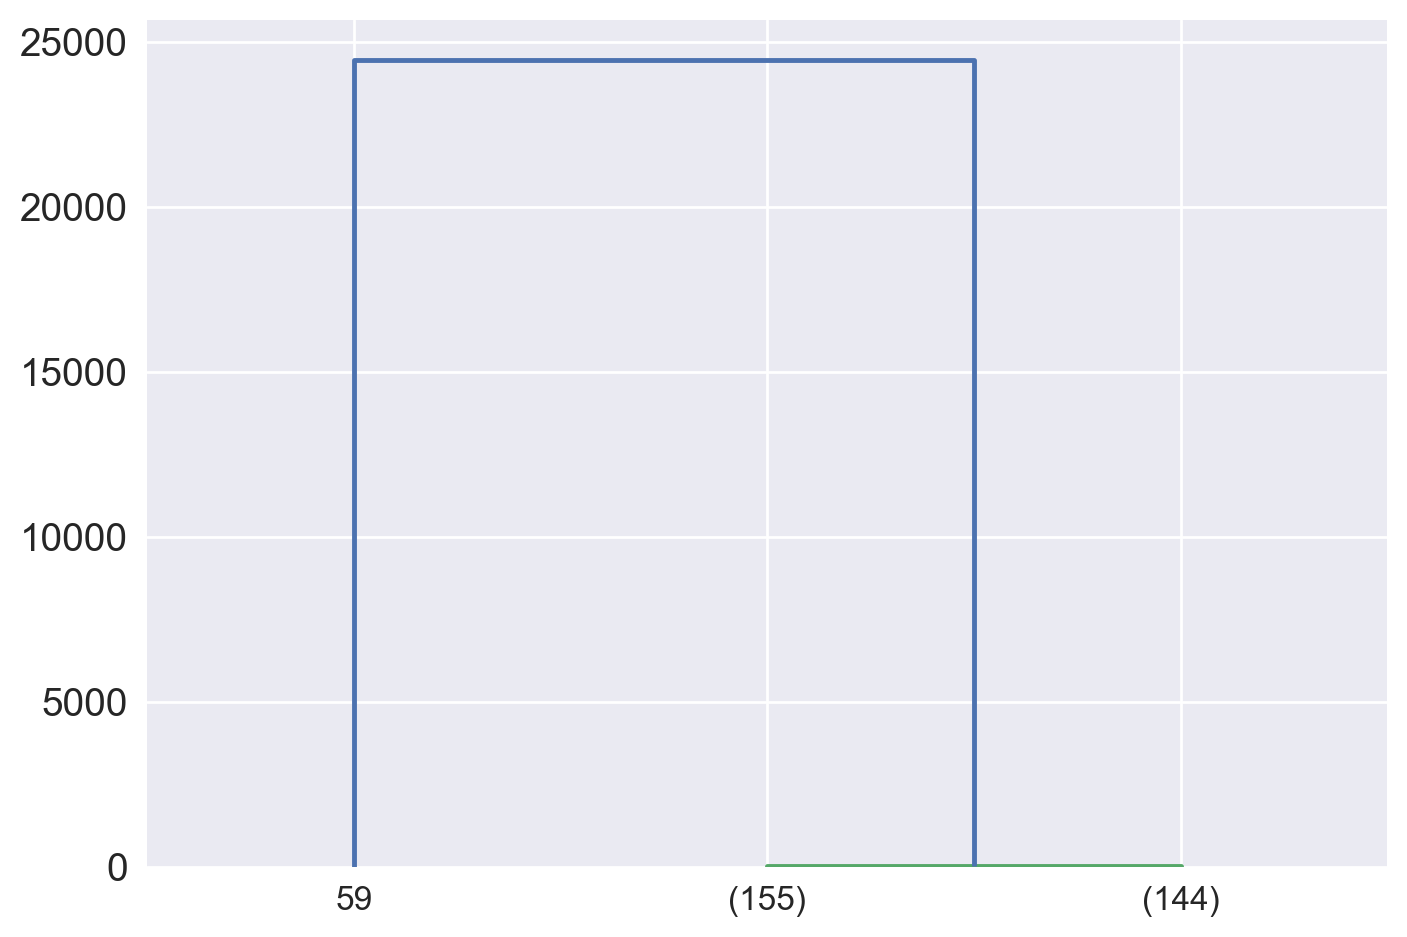

In [176]:
plot_dendrogram(mdl,truncate_mode="level", p=1)

In [165]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [162]:
dir(mdl)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_feature_names',
 '_check_n_features',
 '_estimator_type',
 '_fit',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'affinity',
 'children_',
 'compute_distances',
 'compute_full_tree',
 'connectivity',
 'distance_threshold',
 'fit',
 'fit_predict',
 'get_params',
 'labels_',
 'linkage',
 'memory',
 'n_clusters',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_',
 'set_params']

In [106]:
faux_drivetime.shape

(300, 300)

In [110]:
drivetime_layer.shape

(300, 300, 1)

In [103]:
faux_drivetime.shape

(299, 299)

In [ ]:
distance_driving = pd.DataFrame(np.random.rand(10,10)).round(3)

job_similarity_weight = 10
distance_job_similarity = pd.DataFrame(np.random.rand(10,10)>0.2).astype(float)*job_similarity_weight

Distance_job_similarity 

distance_driving

distance_matrix = np.concatenate((distance_driving.values.reshape(10,10,-1),distance_job_similarity.values.reshape(10,10,-1)),axis=2).sum(axis=2)

mdl = AgglomerativeClustering(n_clusters=2)

mdl.fit_predict(X=distance_matrix)

In [54]:
raw.site_no.value_counts()

       8
283    2
3      2
191    1
198    1
      ..
98     1
97     1
96     1
95     1
0      1
Name: site_no, Length: 291, dtype: int64

In [48]:
raw

,status,site_no,address,full_address,contact,rmvl_rqust,work_description,nbw,owner_phone_comments,projected_hours,regular_,no_parks,flagging,requires_squirt_boom,merge,site_type,notes,trim_date,sign_off
0,Done,1,525 N 125TH ST,"525 N 125TH ST Seattle, WA",DH,,ST CEDAR ON EVANSTON,,,0.75,X,,,False,,RegularCompleted,,6/14/23,H.M.R
1,Done,2,12245 EVANSTON AVE N,"12245 EVANSTON AVE N Seattle, WA",SH,,ST FIR & PINE / CLEAR POLE,,,1.00,X,,,False,,RegularCompleted,,6/15/23,H.M.R
2,Done,3,522 N 122ND ST,"522 N 122ND ST Seattle, WA",DH,,TT APPLE FOR NEUTRAL ON 122ND,,,0.75,X,,,False,,RegularCompleted,,6/15/23,H.M.R
3,In Process,4,523 N 122ND ST,"523 N 122ND ST Seattle, WA",DH,,ST CEDARS & FIR / TTS PINES / CLEAR POLE / WOR...,,,2.00,X,,,False,,RegularIn Process,,,
4,Not Started,5,12043 EVANSTON AVE N,"12043 EVANSTON AVE N Seattle, WA",DH,,TTS DEODAR AND MAPLE / CLEAR POLE,,,1.00,X,,,False,,Regular,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,Action Required,,AV,0.00,0.00,0.00,0.00,0.00,,,,False,0.00,,0.00,0.00,#DIV/0!
296,,,,,JW,0.00,0.00,0.00,0.00,0.00,,,,False,0.00,,0.00,0.00,#DIV/0!
297,,,,,NH,0.00,0.00,0.00,0.00,0.00,,,,False,0.00,,0.00,0.00,#DIV/0!
298,,,,,RO,0.00,0.00,0.00,0.00,0.00,,,,False,0.00,,0.00,0.00,#DIV/0!


In [46]:
raw.requires_squirt_boom.mean()

0.0033333333333333335